In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np

import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import cv2


import time
from ConcatAttn import ConAvg

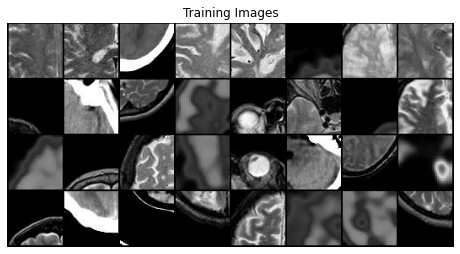

In [2]:
batch_size = 32
workers = 1
ngpu = 1

dataroot = "ConAverage_MED_Dataset_Creation" 

# dataroot = "Refined_patchpairs_me_spect" 


dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
#                                transforms.Resize(256),
#                                transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Grayscale(1),
#                                transforms.Normalize((0.5), (0.5)),
                           ]))

# Create the dataloader
train_loader= torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)


# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# device = 'cuda'

# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [3]:
def imshow(img):
#     img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
    
real_batch[0].shape

torch.Size([32, 1, 64, 64])

# bottleneck= 256

In [4]:
#Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        #Encoder
        self.conv1=nn.Conv2d(1, 64, 3, padding=1)
        self.maxpool1= ConAvg(64, device= 'cuda', size= 2)
        
        self.conv2=nn.Conv2d(64, 128, 3, padding=1) 
        self.maxpool2= ConAvg(128, device= 'cuda' , size= 2)
        
        self.conv3=nn.Conv2d(128, 256, 3, padding=1)
        self.maxpool3=ConAvg(256, device = 'cuda', size=2)
       
        #Decoder 
        self.tconv1=nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.tconv2=nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.tconv3=nn.ConvTranspose2d(64, 1, 2, stride=2)
        self.tanh=nn.Tanh()
        
        #Encoder
    def encoder(self, input):
#         print(input.dtype)
        #print('input')
        #print(input.shape)
        x = self.conv1(input)
        #print('conv1')
        #print(x.shape)
        x = self.maxpool1(x)
        #print('pool1')
       #print(x.shape)
        x = self.conv2(x)
        #print('conv2')
        #print(x.shape)
        x = self.maxpool2(x)
        #print('pool2')
        #print(x.shape)
        
        x = self.conv3(x)
        x = self.maxpool3(x)
        return x
    
    def decoder(self, f_en):  #f_en = encoded features 
        #print('encoded')
        #print(f_en.shape)
        x = self.tconv1(f_en)
        #print('tconv1')
        #print(x.shape)
        x = self.tconv2(x)
        #print('tconv2')
        #print(x.shape)
        x = self.tconv3(x)
        output= self.tanh(x)
        #print('output')
        #print(x.shape)
        return output

# bottleneck=512

In [ ]:
#Define the Convolutional Autoencoder
# class ConvAutoencoder(nn.Module):
#     def __init__(self):
#         super(ConvAutoencoder, self).__init__()
        
#         #Encoder
#         self.conv1=nn.Conv2d(1, 64, 3, padding=1)
#         self.maxpool1= ConAvg(64, device= 'cuda', size= 3)
        
#         self.conv2=nn.Conv2d(64, 128, 3, padding=1) 
#         self.maxpool2= ConAvg(128, device= 'cuda' , size= 3)
        
#         self.conv3=nn.Conv2d(128, 256, 3, padding=1)
#         self.maxpool3=ConAvg(256, device = 'cuda', size= 3)
        
#         self.conv4=nn.Conv2d(256, 512, 3, padding=1)
#         self.maxpool4=ConAvg(512, device = 'cuda', size= 3)
       
#         #Decoder 
#         self.tconv1=nn.ConvTranspose2d(512, 256, 2, stride=2)
#         self.tconv2=nn.ConvTranspose2d(256, 128, 2, stride=2)
#         self.tconv3=nn.ConvTranspose2d(128, 64, 2, stride=2)
#         self.tconv4=nn.ConvTranspose2d(64, 1, 2, stride=2)
#         self.tanh=nn.Tanh()
        
#         #Encoder
#     def encoder(self, input):
# #         print(input.dtype)
#         #print('input')
#         #print(input.shape)
#         x = self.conv1(input)
#         #print('conv1')
#         #print(x.shape)
#         x = self.maxpool1(x)
#         #print('pool1')
#        #print(x.shape)
#         x = self.conv2(x)
#         #print('conv2')
#         #print(x.shape)
#         x = self.maxpool2(x)
#         #print('pool2')
#         #print(x.shape)
        
#         x = self.conv3(x)
#         x = self.maxpool3(x)
        
#         x = self.conv4(x)
#         x = self.maxpool4(x)
#         return x
    
#     def decoder(self, f_en):  #f_en = encoded features 
#         #print('encoded')
#         #print(f_en.shape)
#         x = self.tconv1(f_en)
#         #print('tconv1')
#         #print(x.shape)
#         x = self.tconv2(x)
#         #print('tconv2')
#         #print(x.shape)
#         x = self.tconv3(x)
#         x = self.tconv4(x)
#         output= self.tanh(x)
#         #print('output')
#         #print(x.shape)
#         return output

In [5]:
ConvAutoencoder

__main__.ConvAutoencoder

In [6]:
#Instantiate the model
model = ConvAutoencoder()
print(model)


#Loss function
criterion = nn.MSELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def get_device():
    device = 'cuda'
    return device

device = get_device()
print(device)
model.to(device)

ConvAutoencoder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): ConAvg(
    (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): AvgPool2d(kernel_size=3, stride=2, padding=1)
    (relu): ReLU()
    (attn): SE(
      (gap): AdaptiveAvgPool2d(output_size=1)
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=8, bias=False)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=8, out_features=128, bias=False)
        (3): Sigmoid()
      )
    )
  )
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): ConAvg(
    (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): AvgPool2d(kernel_size=3, stride=2, padding=1)
    (relu): ReLU()
    (attn): SE(
      (gap): AdaptiveAvgPool2d(output_size=1)
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=16, bias=False)
        (1): ReLU(inplace=T

ConvAutoencoder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): ConAvg(
    (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): AvgPool2d(kernel_size=3, stride=2, padding=1)
    (relu): ReLU()
    (attn): SE(
      (gap): AdaptiveAvgPool2d(output_size=1)
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=8, bias=False)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=8, out_features=128, bias=False)
        (3): Sigmoid()
      )
    )
  )
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): ConAvg(
    (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): AvgPool2d(kernel_size=3, stride=2, padding=1)
    (relu): ReLU()
    (attn): SE(
      (gap): AdaptiveAvgPool2d(output_size=1)
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=16, bias=False)
        (1): ReLU(inplace=T

Training

In [8]:
#Epochs
n_epochs = 30

for epoch in range(1, n_epochs+1):
    # monitor training loss
    start = time.time()
    train_loss = 0.0
    print('Epoch: {} \Total Epochs: {:}'.format(epoch, n_epochs))

    #Training
    for data in train_loader:
        
        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()
        en = model.encoder(images)
        en.shape
        # decoder
        outputs = model.decoder(en)
#         outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()  
        train_loss += loss.item()*images.size(0)
        
    train_loss = train_loss/len(train_loader)
    #Trainloss_convergence.append(train_loss)
    end = time.time()
    total_time = end - start
    
    print('- Epoch: {}  ETA: {:.2f} Train Loss: {:.6f}'.format(
            epoch, total_time, train_loss))      
    
    #train_loss = train_loss/len(train_loader)
    #print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 1 \Total Epochs: 30
- Epoch: 1  ETA: 4.78 Train Loss: 0.183664
Epoch: 2 \Total Epochs: 30
- Epoch: 2  ETA: 4.83 Train Loss: 0.153198
Epoch: 3 \Total Epochs: 30
- Epoch: 3  ETA: 4.78 Train Loss: 0.137151
Epoch: 4 \Total Epochs: 30
- Epoch: 4  ETA: 4.82 Train Loss: 0.128072
Epoch: 5 \Total Epochs: 30
- Epoch: 5  ETA: 4.81 Train Loss: 0.117687
Epoch: 6 \Total Epochs: 30
- Epoch: 6  ETA: 4.81 Train Loss: 0.109197
Epoch: 7 \Total Epochs: 30
- Epoch: 7  ETA: 4.83 Train Loss: 0.101015
Epoch: 8 \Total Epochs: 30
- Epoch: 8  ETA: 4.81 Train Loss: 0.095096
Epoch: 9 \Total Epochs: 30
- Epoch: 9  ETA: 4.83 Train Loss: 0.084605
Epoch: 10 \Total Epochs: 30
- Epoch: 10  ETA: 4.85 Train Loss: 0.073950
Epoch: 11 \Total Epochs: 30
- Epoch: 11  ETA: 4.85 Train Loss: 0.064601
Epoch: 12 \Total Epochs: 30
- Epoch: 12  ETA: 4.85 Train Loss: 0.065814
Epoch: 13 \Total Epochs: 30
- Epoch: 13  ETA: 4.85 Train Loss: 0.054178
Epoch: 14 \Total Epochs: 30
- Epoch: 14  ETA: 4.96 Train Loss: 0.052316
Epoch: 15 

Testing

Original Images


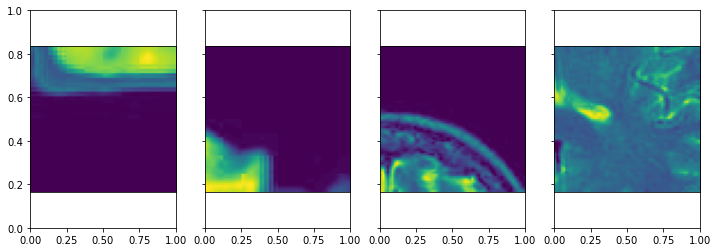

Reconstructed Images


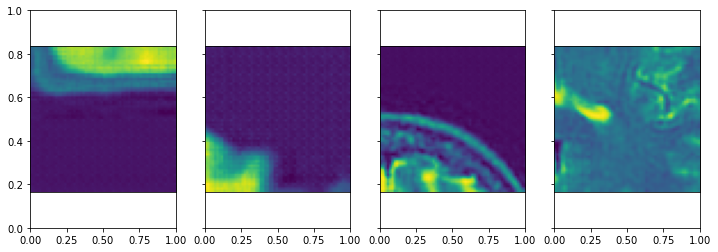

In [9]:
#Batch of test images
batch_size=4

#train_loader= torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(dataset, batch_size,shuffle=True, num_workers=workers)
dataiter = iter(test_loader)
images, labels = dataiter.next()
images1=images.to(device)
#Sample outputs
# output = model(images1)
en = model.encoder(images1)
       
# decoder
output = model.decoder(en)

images = images.numpy()

output = output.view(batch_size, 1, 64, 64)
output =output.cpu()
output = output.detach().numpy()

#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=batch_size, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(1, batch_size, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    #ax.set_title(classes[labels[idx]])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=batch_size, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(1, batch_size, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    #ax.set_title(classes[labels[idx]])
plt.show() 

In [10]:
# Specify a path
PATH = "MedData_LGCA_Pool.pt"

# Save
torch.save(model, PATH)

# Load
trained_model = torch.load(PATH)
trained_model.eval()

ConvAutoencoder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): ConAvg(
    (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): AvgPool2d(kernel_size=3, stride=2, padding=1)
    (relu): ReLU()
    (attn): SE(
      (gap): AdaptiveAvgPool2d(output_size=1)
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=8, bias=False)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=8, out_features=128, bias=False)
        (3): Sigmoid()
      )
    )
  )
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): ConAvg(
    (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): AvgPool2d(kernel_size=3, stride=2, padding=1)
    (relu): ReLU()
    (attn): SE(
      (gap): AdaptiveAvgPool2d(output_size=1)
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=16, bias=False)
        (1): ReLU(inplace=T

Testing Fusion

In [ ]:
#Utility functions to un-normalize and display an image
device='cuda'

def imshow(img):
#     img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

def l1_features(out):
    #d, h, w = out.shape
    l1_norm = np.sum(np.abs(out), axis=0)
    return l1_norm

def weight_map_generation(L1_normed_CT, L1_normed_MR):
    m, n = L1_normed_MR.shape
    # m=252
    # n=252
    unit=1
    weights_CT = np.zeros((m, n))
    weights_MR = np.zeros((m, n))
    for i in range(1, m):
        for j in range(1, n):
            A1 = L1_normed_CT[i-1:i+1, j-1:j+1].sum() / 9
            A2 = L1_normed_MR[i-1:i+1, j-1:j+1].sum() / 9
            weights_CT[(i-2)*unit+1:(i-1)*unit+1, (j-2)*unit+1:(j-1)*unit+1] = A1 / (A1+A2)
            weights_MR[(i-2)*unit+1:(i-1)*unit+1, (j-2)*unit+1:(j-1)*unit+1] = A2 / (A1+A2)
            weights_CT = torch.FloatTensor(weights_CT)
            weights_MR = torch.FloatTensor(weights_MR)
           
    
    return weights_CT, weights_MR
    

In [ ]:
def Convert2normalized_Tensor(image):
    image = image.transpose((2, 0, 1))
    image1 = np.array(image, dtype='float32')
    image2= image1/255.
    img_t = torch.FloatTensor(image2)
    img_4D=torch.unsqueeze(img_t,0)
    img_4D_cuda=img_4D.to(device)
    return img_4D_cuda

def Convert2CPU3D_Tensor(tensor_ip):
    tensor_ip1 =tensor_ip.cpu()
    tensor_ip2=torch.squeeze(tensor_ip1, 0)
    tensor_ip3= tensor_ip2.detach().numpy()
    return tensor_ip3

def show_and_save(decoded_image):
    Fused_image=Convert2CPU3D_Tensor(decoded_image)
    Fused_image.shape
    Fused=np.transpose(Fused_image, (1, 2, 0))
    plt.imshow(Fused)
    Fused_final = cv2.convertScaleAbs(Fused, alpha=(255.0))
    cv2.imwrite('Fused.jpg', Fused_final)
    

In [ ]:
for i in range(1, 15):
    CT = cv2.imread('Med_CT/CT/CT_'  + str(i) + '.jpg')
    MR = cv2.imread('Med_MR/MR/MR_'  + str(i) + '.jpg')
    
    CT_img=CT[:,:,0]
    #CT_img.shape

    CT_img_3D=np.expand_dims(CT_img, axis=2)
    #img1_3D.shape
    
    MR_img = MR[:,:,0]
    #img_MR.shape 

    MR_img_3D = np.expand_dims(MR_img, axis=2)
    #img_MR_3D.shape
    
    CT_encoded=trained_model.encoder(Convert2normalized_Tensor(CT_img_3D))
    MR_encoded=trained_model.encoder(Convert2normalized_Tensor(MR_img_3D))
    
    
    CT_feature_L1norm=l1_features(Convert2CPU3D_Tensor(CT_encoded))
    MR_feature_L1norm=l1_features(Convert2CPU3D_Tensor(MR_encoded))
    
    wmap_ct, wmap_mr=weight_map_generation(CT_feature_L1norm,MR_feature_L1norm)
    wmap_ct=wmap_ct.to(device)
    wmap_mr=wmap_mr.to(device)
    Fused_encoded=(wmap_ct*CT_encoded)+(wmap_mr*MR_encoded)
    
    
    
    decoded_image = trained_model.decoder(Fused_encoded)
    # show_and_save(decoded_image)
    Fused_image=Convert2CPU3D_Tensor(decoded_image)
    Fused_image.shape
    Fused=np.transpose(Fused_image, (1, 2, 0))
    # plt.imshow(Fused)
    Fused_final = cv2.convertScaleAbs(Fused, alpha=(255.0))
    #cv2.imwrite('Med_Trained_AE_ConAverage_Fusion_Results/Fused/Fused_'  + str(i) + '.jpg', Fused_final)
    rows = 1
    columns = 3
    fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(rows, columns, 1)
    plt.title("CT Image")
    plt.imshow(CT, cmap='gray')
    fig.add_subplot(rows, columns, 2)
    plt.title("MR Image")
    plt.imshow(MR, cmap='gray')
    fig.add_subplot(rows, columns, 3)
    plt.title("Fused Image")
    plt.imshow(Fused_final, cmap='gray')